### Clouds : test clouds 3D with NEXT MC events

G. Díaz, J. A Hernando


May 2021

In [45]:
#%matplotlib inline 

%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [46]:
import numpy             as np
import pandas            as pd
import tables            as tb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

plt.rcParams['image.cmap'] = 'rainbow'

In [47]:
import hipy.utils        as ut
import hipy.pltext       as pltext
#import hipy.hfit         as hfit

import clouds.clouds    as clouds
import clouds.graphs    as graphs
import clouds.pltclouds as pltclouds

#import bes.bes           as bes
#import bes.clouds        as clouds
#import next.reco.chits      as chits
#import next.reco.display    as nplay


In [48]:
pltext.style()

import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Tue May 11 16:25:55 2021


In [49]:
#import os
import re
import glob
#import numpy  as np
#import pandas as pd
#import tables as tb

#import matplotlib
#from matplotlib import cm
#from matplotlib import pyplot as plt

#import clouds
#import pltclouds

In [6]:
get_file_number = lambda filename: int(re.findall("_[0-9]+_", filename)[0][1:-1])

def split_hits(hitsdf, weight="E"):
    
    xyz = hitsdf[["X", "Y", "Z"]].values
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    w = hitsdf[weight].values
    
    return x, y, z, w

# ojo
#fname = '/home/hernando/data/NEW/MC/bb0nu_esmeralda/map_8264.h5'
fname = '/Users/hernando/investigacion/NEXT/data/MC/NEW/bb0nu_esmeralda/map_8264.h5'
maps_te = pd.read_hdf(fname, "time_evolution")
dv = maps_te.dv.mean()

In [53]:
#datadir   = "/home/hernando/data/NEW/MC/bb0nu_esmeralda/"
datadir   = "/Users/hernando/investigacion/NEXT/data/MC/NEW/bb0nu_esmeralda/"
files     = glob.glob(datadir + '*.h5')
def file_number(file):
    fname = file .split('/')[-1]
    ifile = fname.split('_')[1]
    return str(ifile)
#print(files)
filenames = sorted(files, key = file_number)
print('total files', len(filenames), get_file_number(filenames[1]))

total files 501 1


In [8]:
#filename = np.random.choice(filenames)
#print(filename)
#filename = '/home/hernando/data/NEW/MC/bb0nu_esmeralda/esmeralda_321_0nubb.h5'
#print("File number", get_file_number(filename))

In [9]:
# events good:  3214
# File number 125 , Event 1252
# filename, event  =  360 ,  3604
# filename, event  =  379 ,  3798
# filename, event  =  25 ,  256


# interesing problematic events
# filename, event  =  190 ,  1902

# Interesting events
# filename, event  =  490 ,  4901
# filename, event  =  449 ,  4493



In [154]:
def get_event(filename = None, event = None):
    filename = np.random.choice(filenames) if filename is None else filename

    CHITS_lowTh  = pd.read_hdf(filename, "/CHITS/lowTh") .groupby("event")
    CHITS_highTh = pd.read_hdf(filename, "/CHITS/highTh").groupby("event")

    MChits = pd.read_hdf(filename, "MC/hits").groupby("event_id")
    data_events = pd.read_hdf(filename, "Run/events")
    event       = np.random.choice(data_events["evt_number"]) if israndom else event
    print('filename, event  = ', get_file_number(filename), ', ', event)
    
    low  = CHITS_lowTh .get_group(event)
    high = CHITS_highTh.get_group(event)
    true = MChits      .get_group(event)

    x, y, z, w = split_hits(low, weight="E")
    coors = (x, y, z)
    ene   = 1e-5 * w

    mcx, mcy, mcz = true["x"].values, true["y"].values, dv*true["z"].values
    mccoors = (mcx, mcy, mcz)
    mcene, mctime = true["energy"].values, true['time'].values
    
    print('Energy MC ', np.sum(enemc), ', RC ', np.sum(ene))
    
    if (np.sum(ene) <= 2.1): 
        return get_event()
    
    return coors, ene, mccoors, mcene, mctime 
    

In [176]:
coors, ene, mccoors, mcene, mctime = get_event()

filename, event  =  48 ,  487
Energy MC  2.3883443 , RC  2.0988245981979374
filename, event  =  310 ,  3103
Energy MC  2.3883443 , RC  0.939385886514932
filename, event  =  39 ,  394
Energy MC  2.3883443 , RC  2.2527336833000184


## Draw MC event

<IPython.core.display.Javascript object>


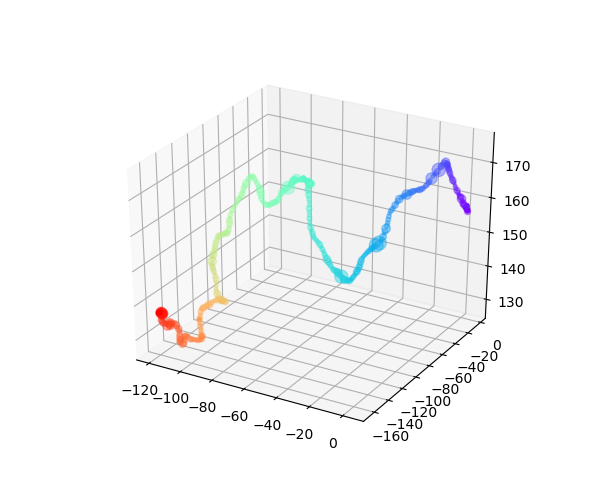

In [182]:
subplot = pltext.canvas(1, 1)
plt.gcf().add_subplot(1, 1 ,1, projection = '3d')
scale  = mctime/np.max(mctime)
size   = mcene/np.max(mcene)
p = plt.gca().scatter(*mccoors, c = scale , s = 100 * size, marker = 'o', alpha = 0.4);

In [157]:
#pltclouds.plot_tview(coorsmc, enemc, timemc)

## Draw Reco

In [178]:
#pltclouds.plot_xyview(coors, ene, coorsmc, enemc)
cells_select = clouds.cells_select
def draw_cloud(bins, mask, cells, value, cut = None, **kargs):
    plt.figure(figsize = (6, 6))
    pltclouds.draw_voxels(bins, mask, cells, alpha = 0.01);
    scale = pltclouds._scale(value)
    cut   = np.min(value) if cut is None else cut
    sel   = value >= cut
    plt.gca().scatter(*cells_select(cells, sel), c = scale[sel], s = 20 * scale[sel], **kargs);
    

In [180]:
bins, mask, cells, df = clouds.clouds(coors, steps, ene)

<IPython.core.display.Javascript object>


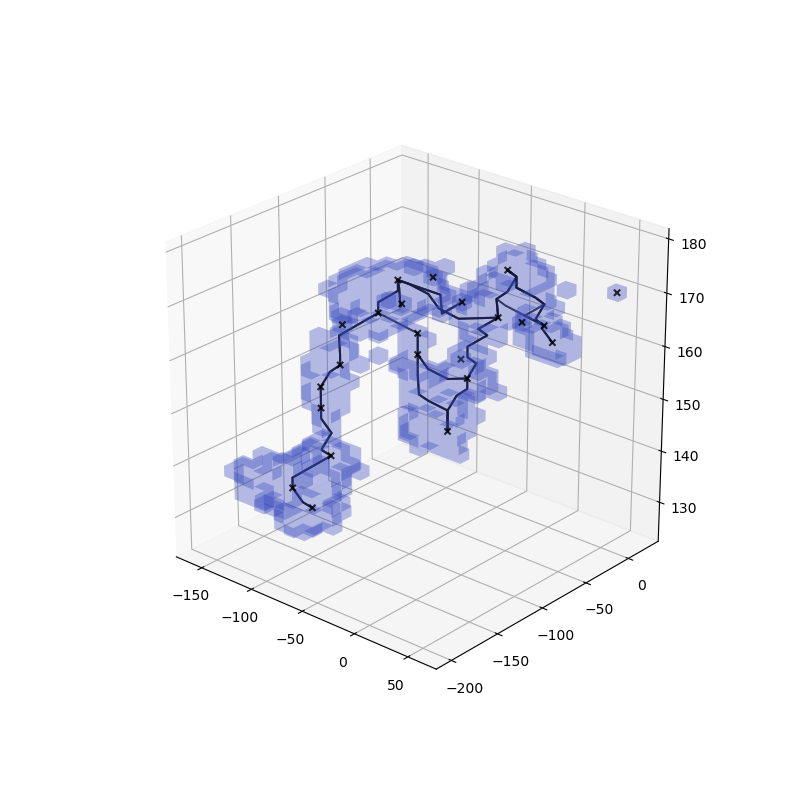

In [181]:
plt.figure(figsize = (8, 8))
pltclouds.draw_cloud(cells, bins, df);

<IPython.core.display.Javascript object>


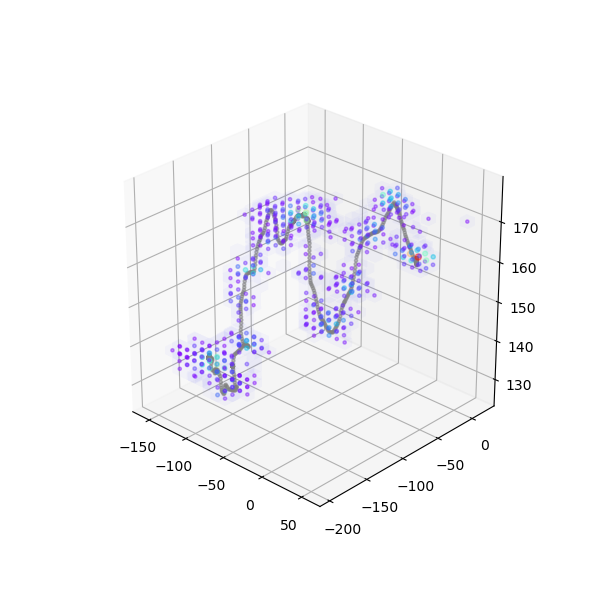

In [183]:
steps = (10, 10, 2)
bins, mask, cells, df = clouds.clouds(coors, steps, ene)
draw_cloud(bins, mask, cells, -df.laplacian.values, 0., alpha = 0.4, marker = 'o')
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.5, c = 'gray');

#plt.figure(figsize = (6, 6))
#pltclouds.draw_voxels(bins, mask, cells, alpha = 0.1);
#plt.gca().scatter(*cells_select8, c = df.energy, alpha = 0.2);

<IPython.core.display.Javascript object>


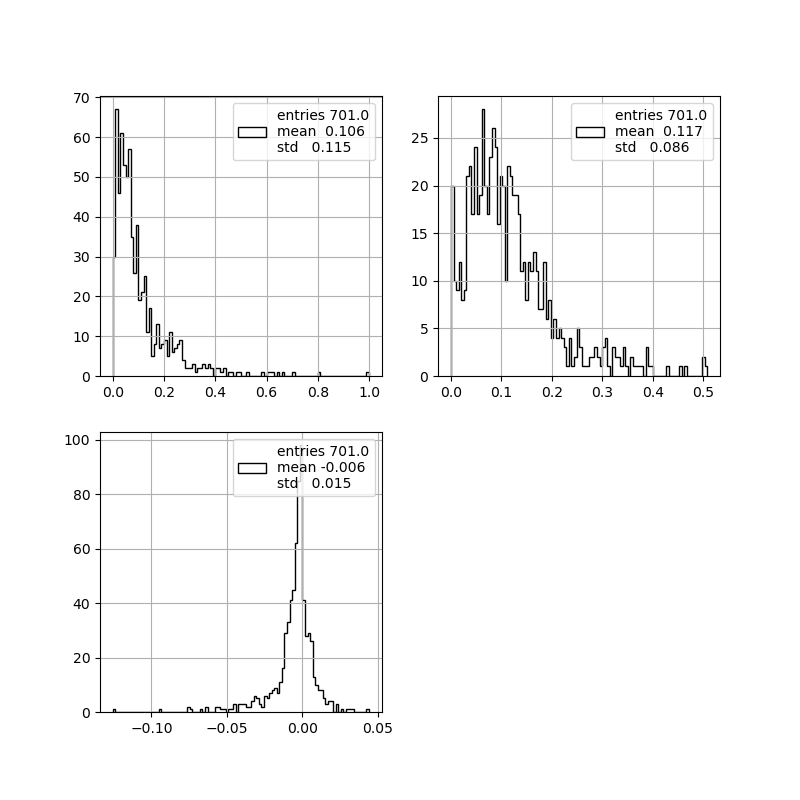

In [184]:
subplot = pltext.canvas(4, 2, 4, 4)
subplot(1)
pltext.hist(df.energy, 100);
subplot(2)
pltext.hist(df.vgrad, 100);
subplot(3)
pltext.hist(df.laplacian, 100);

## Test Graph

In [196]:
weights  = df.evalue.values
graph    = graphs._graph(bins, mask, cells, weights)

In [197]:
print(graph.nlink)

[[ -1  -1  -1  -1  -1  -1 476  -1 311  -1  -1  -1  -1  -1  -1  -1  -1 418
   -1 506  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1 112  -1  -1 101  -1  -1  -1  -1  -1  -1  -1
   -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1 482  -1  -1  -1  -1  -1  -1 428  -1  -1  -1  -1  -1
   -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1 639  -1  -1  -1  -1
   -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1 612  -1  -1  -1  -1  -1  -1 669  -1  -1  -1  -1
   -1  -1  -1  -1  -1]
 [ -1  -1 492  -1  -1  -1 529  -1  -1  -1  -1  -1 485  -1  -1  -1  -1  -1
   -1  -1  -1  -1  -1]
 [520  -1  -1  -1 577 570  -1  -1  -1  -1  -1  -1  -1 616  -1  -1  -1  -1
   -1  -1  -1  -1  -1]
 [ -1 181  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1  -1 227  -1  -1  -1
   -1  -1  -1  -1  -1]
 [310  -1  -1  -1  -1  -1  -1  -1  -1 197  -1  -1  -1  -1  -1 344  -1  -1
   -1  -1  -1  -1  -1]
 [ -1  -1  -1  -1  -1  -1  -1  -1 254  -1  -1 187  -1  -1  -1  -1  -1  -1
   -1  -1  -1  -1  -1]
 [ -1 108  -1  -1  -1  -1  -1 

In [198]:
print((1000 * graph.elink).astype(int))

[[  0   0   0   0   0   0  68   0 521   0   0   0   0   0   0   0   0  51
    0  19   0   0   0]
 [  0   0   0   0   0   0   0 473   0   0 573   0   0   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0 457   0   0   0   0   0   0 157   0   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 508   0   0   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0 453   0   0   0   0   0   0 180   0   0   0   0
    0   0   0   0   0]
 [  0   0 457   0   0   0 273   0   0   0   0   0 181   0   0   0   0   0
    0   0   0   0   0]
 [ 68   0   0   0 453 273   0   0   0   0   0   0   0 151   0   0   0   0
    0   0   0   0   0]
 [  0 473   0   0   0   0   0   0   0   0   0   0   0   0  89   0   0   0
    0   0   0   0   0]
 [521   0   0   0   0   0   0   0   0 242   0   0   0   0   0 216   0   0
    0   0   0   0   0]
 [  0   0   0   0   0   0   0   0 242   0   0 367   0   0   0   0   0   0
    0   0   0   0   0]
 [  0 573   0   0   0   0   0 

645 701


<IPython.core.display.Javascript object>


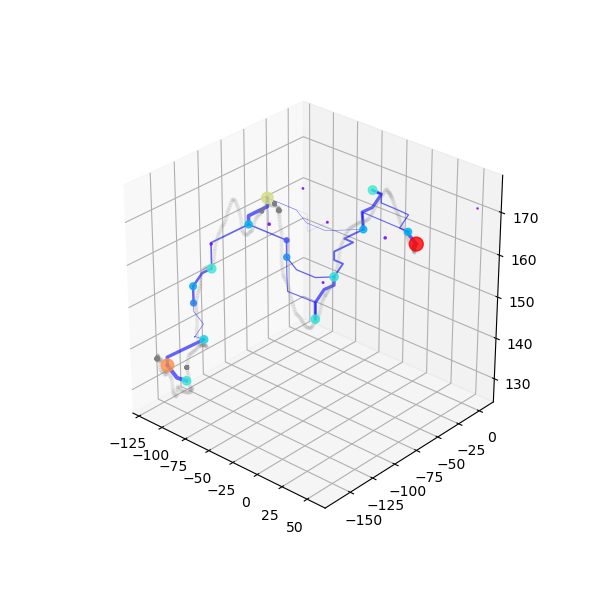

[(476, 520), (311, 310), (418, 463), (506, 551), (112, 181), (101, 108), (482, 492), (428, 396), (639, 667), (612, 577), (669, 659), (529, 570), (485, 440), (616, 659), (227, 238), (197, 254), (344, 400), (187, 172), (171, 170), (399, 400)]


In [200]:
epath = graph.epath
print(len(enes), len(epath))
nlink = graph.nlink
plt.figure(figsize = (6, 6))
pltclouds.draw_graph(cells, weights, epath, nlink, link_size = 10)
plt.gca().scatter(*mccoors, marker = '.', alpha = 0.1, c = 'gray');